## 1. Import Relevant Libraries

In [1]:
!pip install xgboost

In [38]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
import os
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16

### 1a. CUDA GPU Config

In [39]:
#setting growth limit on the gpus to avoid time out errors
gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## 2. Load Images

In [40]:
positive1 = os.path.join('Facial Recognition App','data', 'positive')
positive2 = os.path.join('Facial Recognition App','data', 'anchor')
negative = os.path.join('Facial Recognition App','data', 'negative')

In [41]:
#looping through our folder using the tf.data library to take 900 of each class
positive1 = tf.data.Dataset.list_files(positive1+'\*.jpg').take(400)
positive2 = tf.data.Dataset.list_files(positive2+'\*.jpg').take(500)
negative = tf.data.Dataset.list_files(negative+'\*.jpg').take(900)

## 3. Exploratory Data Analysis & Feature Engineering


1. Display Image sample
2. Preprocess image
3. normalize images by dividing by 255
4. Label Data
5. convert dataset to np array

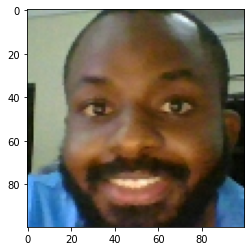

In [42]:
x = tf.io.decode_jpeg(tf.io.read_file(positive1.as_numpy_iterator().next()))
y = tf.image.resize(x, (100,100))
y = y/255
plt.imshow(y)

In [43]:
def preprocess(filepath):
    #load image from file path that returns image in encoded format
    img_encoded = tf.io.read_file(filepath)
    #decode image and load as a matrix
    img = tf.io.decode_jpeg(img_encoded)
    #resize image
    img = tf.image.resize(img, (100,100))
    #scaling image to be between 0 & 1
    img = img/255
    
    return img
    

### 3b. Labeling the Dataset

In [44]:
positive1 = tf.data.Dataset.zip((positive1, tf.data.Dataset.from_tensor_slices(tf.ones(400))))
positive2 = tf.data.Dataset.zip((positive2, tf.data.Dataset.from_tensor_slices(tf.ones(500))))
negative = tf.data.Dataset.zip((negative, tf.data.Dataset.from_tensor_slices(tf.zeros(900))))

In [45]:
#joining the dataset
dataset = positive1.concatenate(negative).concatenate(positive2)

In [46]:
#here we create a method to separate the label data from the feature and preprocess the feature data, return them 
def preprocess_all(features, label):
    return (preprocess(features), label)

#using the map method to iterate over the dataset 
data_preprocessed = dataset.map(preprocess_all)

shuffling out dataset to ensure that the dataset is properly distributed to avoid training bias, 
and we will cache the data in memory so that subsequent iterations will be from cached data

In [47]:
data_preprocessed = data_preprocessed.shuffle(buffer_size=2000)

In [48]:
data_preprocessed_c = data_preprocessed.cache()

In [49]:
print(list(data_preprocessed)[100:105])
print(list(data_preprocessed)[0:4])

[(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.63848037, 0.6933824 , 0.63259804],
        [0.6362745 , 0.6933824 , 0.6357843 ],
        [0.62647057, 0.6960784 , 0.6377451 ],
        ...,
        [0.41691175, 0.46789217, 0.43235293],
        [0.40269607, 0.45367646, 0.41446078],
        [0.40392157, 0.46666667, 0.42009804]],

       [[0.6546569 , 0.70367646, 0.6664216 ],
        [0.6460784 , 0.6992647 , 0.6615196 ],
        [0.64166665, 0.70367646, 0.6617647 ],
        ...,
        [0.40539217, 0.44852942, 0.4269608 ],
        [0.4134804 , 0.4625    , 0.4360294 ],
        [0.4137255 , 0.4627451 , 0.43039215]],

       [[0.6482843 , 0.69142157, 0.660049  ],
        [0.6313726 , 0.68235296, 0.654902  ],
        [0.63284314, 0.68602943, 0.6519608 ],
        ...,
        [0.41789216, 0.45367646, 0.44166666],
        [0.4247549 , 0.46200982, 0.4477941 ],
        [0.42647058, 0.46372548, 0.4490196 ]],

       ...,

       [[0.33504903, 0.6482843 , 0.9816176 ],
        [0.

[(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.00784314, 0.        ],
        [0.        , 0.00490196, 0.        ],
        [0.        , 0.00392157, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ],
        [0.        , 0.00392157, 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.00098039, 0.        ],
        [0.        , 0.00318627, 0.        ],
        [0.        , 0.00392157, 0.        ]],

       ...,

       [[0.00490196, 0.01176471, 0.        ],
        [0.

In [50]:
from sklearn.model_selection import train_test_split


In [51]:
data_batch=data_preprocessed_c.batch(1800)

In [52]:
data_batch.as_numpy_iterator().next()[0].shape

(1800, 100, 100, 3)

In [53]:
x = data_batch.as_numpy_iterator().next()[0]
y = data_batch.as_numpy_iterator().next()[1]


In [54]:
from sklearn.model_selection import train_test_split

In [55]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)

In [56]:
x_train.shape, x_test.shape

((1260, 100, 100, 3), (540, 100, 100, 3))

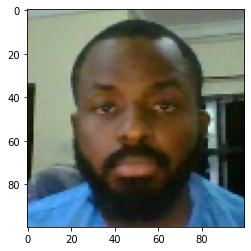

In [57]:
plt.imshow(x_train[5])

In [58]:
y_train[5]

1.0

### 4. VGG MODEL

In [59]:
VGG_model = VGG16(weights = 'imagenet', include_top=False, input_shape=(100,100,3))
#the original VGG network requires 224x224 image if you are using the dense layers.

In [60]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [61]:
#we need to make the trainable params = 0 since we are only using the VGG model as a feature extractor and not as a
#deep neural network

In [62]:
for layer in VGG_model.layers:
    layer.trainable = False

In [65]:
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [66]:
#now will extract features from the convolutional neural network, note that it won't train even though we call predict
#because the trainable parameters have been removed, but the weights and biases will be generated based on the total 
#params
feature_extractor = VGG_model.predict(x_train)

Next we will flatten the array like the last layer of a convolutional neural network

In [67]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

x_for_training = features

In [68]:
x_for_training.shape

(1260, 4608)

In [69]:
import xgboost as xgb

In [130]:
model = xgb.XGBClassifier()
model.fit(x_for_training, y_train)

C:\Users\HP OMEN\.conda\envs\cnnpy\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


ValueError: Please reshape the input data into 2-dimensional matrix.

In [71]:
x_test_feature = VGG_model.predict(x_test)
x_test_features = x_test_feature.reshape(x_test_feature.shape[0], -1)

In [72]:
prediction = model.predict(x_test_features)

In [73]:
prediction

array([0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,

In [75]:
from sklearn import metrics

In [76]:
print("Accuracy", metrics.accuracy_score(y_test,prediction))

Accuracy 0.9962962962962963


In [77]:
from sklearn.metrics import confusion_matrix

In [78]:
cm = confusion_matrix(y_test, prediction)

<AxesSubplot:>

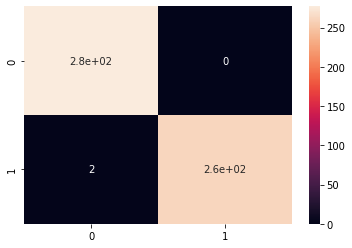

In [80]:
sns.heatmap(cm, annot=True)

In [119]:
test_image = preprocess('test4.jpg')

In [120]:
test_image

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.7627451 , 0.7470588 , 0.70392156],
        [0.6990196 , 0.685049  , 0.64166665],
        [0.6637255 , 0.6607843 , 0.622549  ],
        ...,
        [0.85882354, 0.8509804 , 0.8039216 ],
        [0.8485294 , 0.8377451 , 0.7995098 ],
        [0.85808825, 0.842402  , 0.80710787]],

       [[0.8144608 , 0.80196077, 0.7438725 ],
        [0.79387254, 0.78063726, 0.72990197],
        [0.76029414, 0.75147057, 0.6985294 ],
        ...,
        [0.85612744, 0.8482843 , 0.79534316],
        [0.8507353 , 0.84289217, 0.79362744],
        [0.86470586, 0.8490196 , 0.80490196]],

       [[0.8421569 , 0.8303922 , 0.7637255 ],
        [0.84117645, 0.82941175, 0.7632353 ],
        [0.8247549 , 0.8129902 , 0.74828434],
        ...,
        [0.8833333 , 0.8784314 , 0.81078434],
        [0.8740196 , 0.8691176 , 0.8014706 ],
        [0.8786765 , 0.8659314 , 0.810049  ]],

       ...,

       [[0.14705883, 0.17916666, 0.34632352],
        [0.12

In [121]:
#VGG_model.predict(test_image)
test_image_a=np.array(test_image)

In [122]:
test_image_a = test_image.numpy()

In [123]:
test_image = test_image_a.reshape((1,100,100,3))

In [124]:
test_image = VGG_model.predict(test_image)
test_image = test_image.reshape(test_image.shape[0], -1)

In [125]:
test_image.shape

(1, 4608)

In [126]:
model.predict(test_image)

array([0])

Tomorrow we will work on avoiding overfitting by applying early stopping; read this article: https://machinelearningmastery.com/avoid-overfitting-by-early-stopping-with-xgboost-in-python/

In [131]:
eval_set = [(x_for_training,y_train), (x_test_features, y_test)]

In [132]:
model = xgb.XGBClassifier()
model.fit(x_for_training, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.00159	validation_0-logloss:0.44112	validation_1-error:0.00926	validation_1-logloss:0.44493
[1]	validation_0-error:0.00000	validation_0-logloss:0.30057	validation_1-error:0.00926	validation_1-logloss:0.30771
[2]	validation_0-error:0.00000	validation_0-logloss:0.21163	validation_1-error:0.00926	validation_1-logloss:0.22082
[3]	validation_0-error:0.00000	validation_0-logloss:0.15201	validation_1-error:0.00926	validation_1-logloss:0.16362
[4]	validation_0-error:0.00000	validation_0-logloss:0.11082	validation_1-error:0.00926	validation_1-logloss:0.12363
[5]	validation_0-error:0.00000	validation_0-logloss:0.08158	validation_1-error:0.00926	validation_1-logloss:0.09644
[6]	validation_0-error:0.00000	validation_0-logloss:0.06064	validation_1-error:0.00926	validation_1-logloss:0.07408
[7]	validation_0-error:0.00000	validation_0-logloss:0.04543	validation_1-error:0.00926	validation_1-logloss:0.05746
[8]	validation_0-error:0.00000	validation_0-logloss:0.03430	validation_1

[71]	validation_0-error:0.00000	validation_0-logloss:0.00156	validation_1-error:0.00370	validation_1-logloss:0.00680
[72]	validation_0-error:0.00000	validation_0-logloss:0.00156	validation_1-error:0.00370	validation_1-logloss:0.00680
[73]	validation_0-error:0.00000	validation_0-logloss:0.00156	validation_1-error:0.00370	validation_1-logloss:0.00680
[74]	validation_0-error:0.00000	validation_0-logloss:0.00156	validation_1-error:0.00370	validation_1-logloss:0.00680
[75]	validation_0-error:0.00000	validation_0-logloss:0.00156	validation_1-error:0.00370	validation_1-logloss:0.00680
[76]	validation_0-error:0.00000	validation_0-logloss:0.00156	validation_1-error:0.00370	validation_1-logloss:0.00680
[77]	validation_0-error:0.00000	validation_0-logloss:0.00156	validation_1-error:0.00370	validation_1-logloss:0.00680
[78]	validation_0-error:0.00000	validation_0-logloss:0.00156	validation_1-error:0.00370	validation_1-logloss:0.00680
[79]	validation_0-error:0.00000	validation_0-logloss:0.00156	val

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)